# We start by importing the dependencies and setting the parameters
- NUM_ITEMS => amount of different items in a solution
- MAX_WEIGHT => maximum amount of weight our knapsack can hold
- MUTATION_RATE => mutation occurs in that amount of genes
- POP_SIZE => size of our population of solutions
- TOURNAMENT_SIZE => how big the tournament rounds are
- MAX_VALUES => not related to gp, sets the maximum for the value and weight of each item
- DAMPENING => sets whether we only pick the new generation if it performs better than the old one or always

In [23]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from time import perf_counter

from knapsack_dp import knapsack_dp

# Define the parameters of the problem and parameters for the algorithm
NUM_ITEMS = 50
MAX_WEIGHT = 500
MUTATION_RATE = 0.1
NUM_ROUNDS = 100
POP_SIZE = 128
TOURNAMENT_SIZE = 8
MAX_VALUES = 10
DAMPENING = True

# EV of a random solution will be around MAX_VALUES / 2 times NUM_ITEMS / 2

# We then generate the items our algorithm will have to work with

In [24]:
# Items will act as a constant variable for the whole script
def generate_items(num_items, max_values):
    return [(random.randint(1, max_values), random.randint(1, max_values)) for _ in range(num_items)]

# Next we define our fitness function
## We will sum the values in the solution list and return either its value if it is less than max_weight or 0 if it is more

In [25]:
# Define the fitness function
def calculate_fitness(solution, max_weight, items):
    weight = 0
    value = 0

    for i, val in enumerate(solution):
        if val:
            weight += items[i][0]
            value += items[i][1]

    if weight > max_weight:
        return 0

    return value

# Here we define the functions which will calculate crossover and mutation

## We define an interleaved crossover which will iterate over both parents and create children with opposite genes

## For mutation iterate over the child and randomly flip the current item if we roll mutation

In [26]:
# Define the genetic operators
def crossover(parent1, parent2):
    # Create a new child by combining the attributes of the parents
    child0 = []
    child1 = []

    # Picking random values from each parent by interleaved crossover
    for i in range(len(parent1)):
        if random.random() < 0.5:
            child0.append(parent1[i])
            child1.append(parent2[i])
        else:
            child0.append(parent2[i])
            child1.append(parent2[i])

    return [child0, child1]

In [27]:
def mutate(child, mutation_rate):
    # Iterate over the solution and flip the bit if mutation occurs
    return [val ^ 1 if random.random() <= mutation_rate else val for val in child]

# Here we generate a population of solutions

## The population consists of lists of length NUM_ITEMS where each item can either be picked up in our solution or not

In [28]:
# Define the initial population
def generate_population(population_size, num_items):
    return [[random.randint(0,1) for _ in range(num_items)] for _ in range(population_size)]

# Here we set up the experiment and generate our items and solutions lists

In [29]:
# Define logging and fitness lists
log = []
fitnesses = []
time_results = {}

# asserting that the population is evenly divisible by 8
assert POP_SIZE % TOURNAMENT_SIZE == 0

# Generate the items and the population
items = generate_items(NUM_ITEMS, MAX_VALUES)
population = generate_population(POP_SIZE, NUM_ITEMS)

# Here is our driver code
## We check the fitness of each solution and then pick the best two solutions out of every tournament group
## After that we build the next generation using the winners of the tournament and mutate the children
## Finally, we set the next generation's population either using dampening or not

In [30]:
# time the code runtime
start_time = perf_counter()

# Run the genetic algorithm
for i in range(NUM_ROUNDS):
    # Evaluate the fitness of each solution
    fitnesses = [calculate_fitness(p, MAX_WEIGHT, items) for p in population]

    # Print the epoch number and the fitness of the best solution in this epoch
    best_score = max(fitnesses)

    # Output the scores every 50 iterations
    if i % 50 == 0:
        print(f"Epoch  {i}: Best fitness = {best_score}")

    # Log the best solution
    log.append(best_score)

    # creating tournament with 8 solutions each, picking best 2 solutions to breed the next generation
    next_generation = []
    for j in range(0, len(population), TOURNAMENT_SIZE):
        tournament_population = population[j:j+TOURNAMENT_SIZE]
        best_tournament = {idx: fitnesses[j+idx] for idx in range(len(tournament_population))}
        best_tournament = dict(sorted(best_tournament.items(), key=lambda item: item[1], reverse=True))

        # Get the 2 best solutions from the tournament
        parent0_idx, parent1_idx = list(best_tournament)[:2]

        # Crossover the best 2 parent solution TOURNAMENT_SIZE / 2 times
        children = [crossover(tournament_population[parent0_idx], tournament_population[parent1_idx]) for _ in range(TOURNAMENT_SIZE // 2)]
        children = list(itertools.chain(*children))

        # A radioactive spider (sometimes) bites the children
        children = [mutate(child, MUTATION_RATE) for child in children]

        # Build the next generation
        next_generation.extend(children)


    """
    EITHER USE DAMPENING OR SKIP DAMPENING

    SKIPPING DAMPENING MEANS THAT THE NEXT GENERATION WILL ONLY BE PICKED FOR THE NEXT ROUND IF IT OUTPERFORMS THE CURRENT GENERATION

    OTHERWISE THE NEW GENERATION WILL ALWAYS BE PICKED WHICH RESULTS IN VARIANCE IN THE BEST SOLUTION
    """

    if DAMPENING:
        # Calculate best scores of new generation
        new_fitnesses = [calculate_fitness(np, MAX_WEIGHT, items) for np in next_generation]
        new_best_score = max(new_fitnesses)

        # If the result after calculating the new results is worse, then ignore that round
        if new_best_score > best_score:
            population = next_generation
    else:
        population = next_generation

end_time = perf_counter()

# Print the final best solution
best_index = fitnesses.index(max(fitnesses))
best_solution = population[best_index]

gp_time = end_time - start_time
time_results["GP"]= gp_time
print(f"Final best solution: {fitnesses[best_index]}")
print(f"Runtime: {gp_time}")

Epoch  0: Best fitness = 215
Epoch  50: Best fitness = 263
Final best solution: 270
Runtime: 0.160701708002307


# Here we compare our solution with a solution for 0-1 Knapsack using Dynamic Programming

> Source: https://www.geeksforgeeks.org/0-1-knapsack-problem-dp-10/

In [31]:
benchmark_start = perf_counter()

# Code defined in the other file
dp_result = knapsack_dp(items, max_weight=MAX_WEIGHT)

benchmark_end = perf_counter()

benchmark_time = benchmark_end - benchmark_start
time_results["DP"] = benchmark_time

print(f"Benchmark Solution: {dp_result}")
print(f"Runtime: {benchmark_time}")

Benchmark Solution: 284
Runtime: 0.005770458999904804


# Plotting the results of the experiment

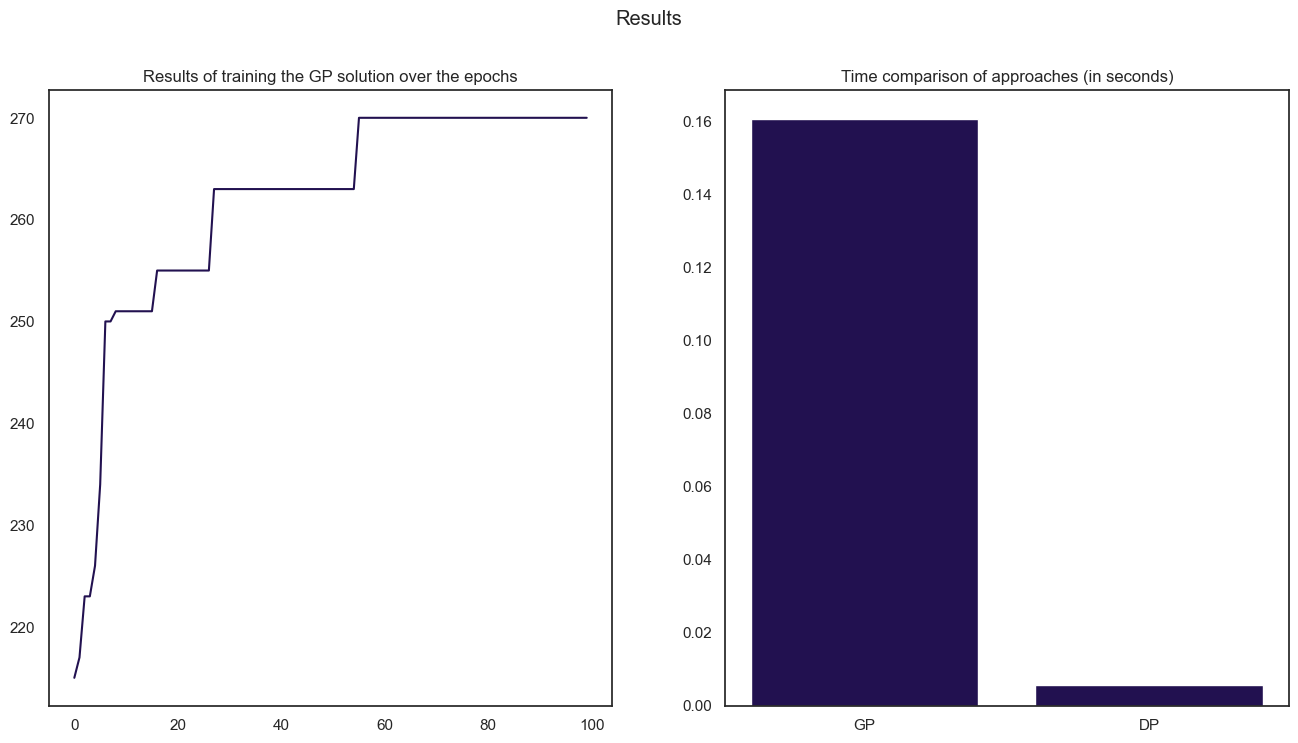

In [32]:
# Plot the fitness of the best solution in each epoch
sns.set_theme(style="white", palette="magma")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Results')

ax1.plot(log)
ax1.set_title("Results of training the GP solution over the epochs")

approaches = time_results.keys()
results = time_results.values()

ax2.bar(approaches, results)
ax2.set_title("Time comparison of approaches (in seconds)")

plt.show()